In [4]:
import numpy as np
import pandas as pd

data = np.load('ihb.npy')
data.shape

(320, 10, 246)

Посмотрим на корреляции между фичами внутри датасета

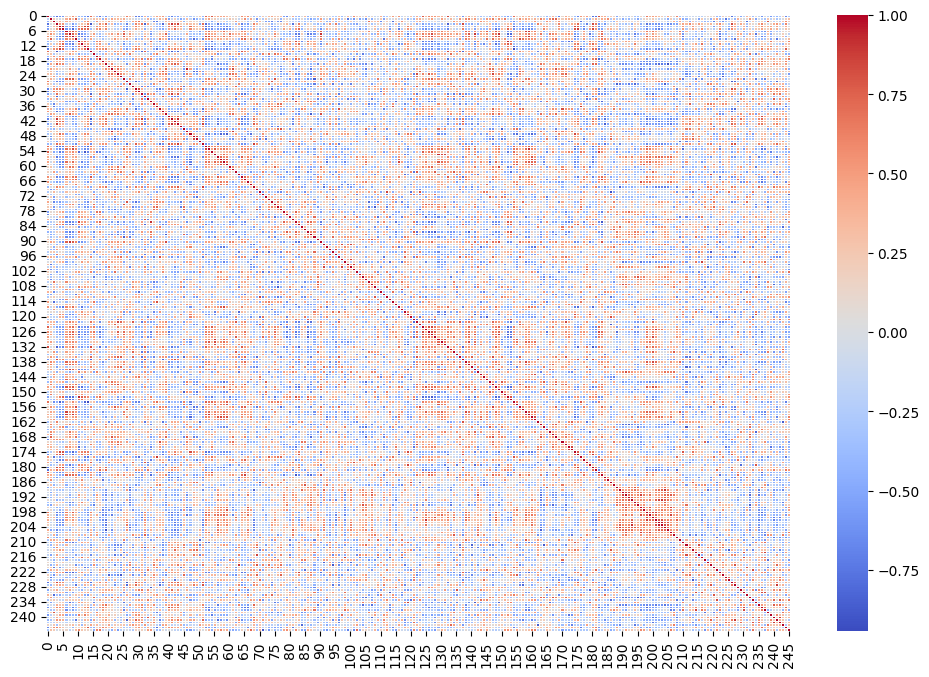

Оставшиеся признаки с низкой корреляцией:
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       236, 237, 238, 239, 240, 241, 242, 243, 244, 245],
      dtype='int64', length=246)


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
subject = data[0]
df_subject = pd.DataFrame(subject)
corr_matrix = df_subject.corr(method='pearson')
threshold = 0.3

low_corr_features = corr_matrix.columns[(corr_matrix.abs() < threshold).any(axis=0)]
df_low_corr = df_subject[low_corr_features]
new_corr_matrix = df_low_corr.corr(method='pearson')
plt.figure(figsize=(12, 8))
sns.heatmap(new_corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()
print("Оставшиеся признаки с низкой корреляцией:")
print(low_corr_features)

Разделим датасеты на два: has_nan c 200 признаками и no_nan с 246 признаками

In [6]:
mask = [np.isnan(data[i]).any() for i in range(data.shape[0])] # смотрим, где nan, а где не nan
len(mask)

320

In [8]:
has_nan = data[mask]
no_nan = data[~np.array(mask)]
has_nan = has_nan[:,:,:200]
print(has_nan.shape, no_nan.shape)

(160, 10, 200) (160, 10, 246)


Найдем корреляции для каждой фичи, для каждого человека для каждой пацы. Т.е. для каждой фичи найдем ее корреляции.

In [9]:
def imp_features(d):
  res = np.array([])
  for i in range(d.shape[2]):
    coef = 0
    for p1 in range(d.shape[0]):
      ts_1 = d[p1, :, i]
      for p2 in range(d.shape[0]):
        ts_2 = d[p2, : , i]
        coef += np.abs(np.corrcoef(ts_1, ts_2)[0, 1])
    res = np.append(res, coef)
  print(f'Done')
  return res

In [64]:
corr_has_nan = imp_features(has_nan)
corr_no_nan = imp_features(no_nan)

Done
Done


Функция сортировки фич по их корреляциям

In [7]:
def sort_for_corr(arr):
    return pd.DataFrame({"Value" : arr}).sort_values("Value", ignore_index=False)

In [8]:
sort_corr_has_nan = sort_for_corr(corr_has_nan)
sort_corr_no_nan = sort_for_corr(corr_no_nan)

Выведем их для наглядности

In [9]:
sort_corr_no_nan

,Value
163,7056.614025
26,7068.659188
225,7071.348029
180,7073.800602
202,7074.168170
...,...
142,7408.894561
174,7424.489505
15,7429.381872
3,7470.132098


In [10]:
sort_corr_has_nan

,Value
54,7075.914052
35,7075.987741
8,7080.529773
69,7095.945369
73,7110.519140
...,...
48,7431.040449
68,7444.543101
16,7460.925144
133,7497.153854


Нормализуем корреляции

In [11]:
sort_has_nan_normalized = pd.DataFrame((sort_corr_has_nan['Value'] - sort_corr_has_nan['Value'].min()) / (sort_corr_has_nan['Value'].max() - sort_corr_has_nan['Value'].min()))
sort_no_nan_normalized = pd.DataFrame((sort_corr_no_nan['Value'] - sort_corr_no_nan['Value'].min()) / (sort_corr_no_nan['Value'].max() - sort_corr_no_nan['Value'].min()))

Совместим фичи по корреляциям, чтобы посмотреть, какие фичи упущены и разместить их в правильном порядке

In [12]:
def find_nearest_indices(sort_corr_has_nan, sort_corr_no_nan):
    index_pairs = []
    not_available_list = []
    for idx1, value1 in zip(sort_corr_has_nan['Value'].index.values, sort_corr_has_nan['Value']):
        best_diff = float('inf')  # Устанавливаем начальное значение на бесконечность
        best_ind = -1
        best_value = 0
        for idx2, value2 in zip(sort_corr_no_nan['Value'].index.values, sort_corr_no_nan['Value']):
            diff = abs(value1 - value2)  # Вычисляем абсолютную разность
            if idx2 not in not_available_list:
                if diff < best_diff:  # Если текущая разность меньше лучшей
                    best_diff = diff
                    best_ind = idx2
                    best_value = value2
        not_available_list.append(best_ind)
        index_pairs.append((idx1, best_ind, best_diff, value1, best_value))  # Добавляем найденные индексы и разность

    result_df = pd.DataFrame(index_pairs, columns=["ind_has_nan", "ind_no_nan", "diff", 'value_has_nan', 'value_no_nan'])

    return result_df

In [13]:
prop = find_nearest_indices(sort_has_nan_normalized, sort_no_nan_normalized)

Посмотрим, визуально

In [16]:
prop

,ind_has_nan,ind_no_nan,diff,value_has_nan,value_no_nan
0,54,163,0.000000,0.000000,0.000000
1,35,26,0.028914,0.000152,0.029066
2,8,225,0.026059,0.009495,0.035554
3,69,180,0.000267,0.041206,0.041473
4,73,88,0.000396,0.071185,0.070789
...,...,...,...,...,...
195,48,17,0.021183,0.730516,0.751699
196,68,110,0.006414,0.758292,0.751878
197,16,185,0.009937,0.791991,0.782054
198,133,142,0.016436,0.866516,0.850080


Нарисуем графики, как распредлены наши фичи по суммарных нормализованных фич

In [18]:
np_has_nan = sort_has_nan_normalized.to_numpy().flatten()
test = prop["value_no_nan"].to_numpy() # урезаем no_nan так, чтобы корреляционно фичи совпадали с has_nan

Нарисуем 3 графика \\
1) Изменение суммарной корреляции для каждой фичи no_nan \\
2) Изменение суммарной корреляции для каждой фичи has_nan \\
3) Совместно на 1 графике \\


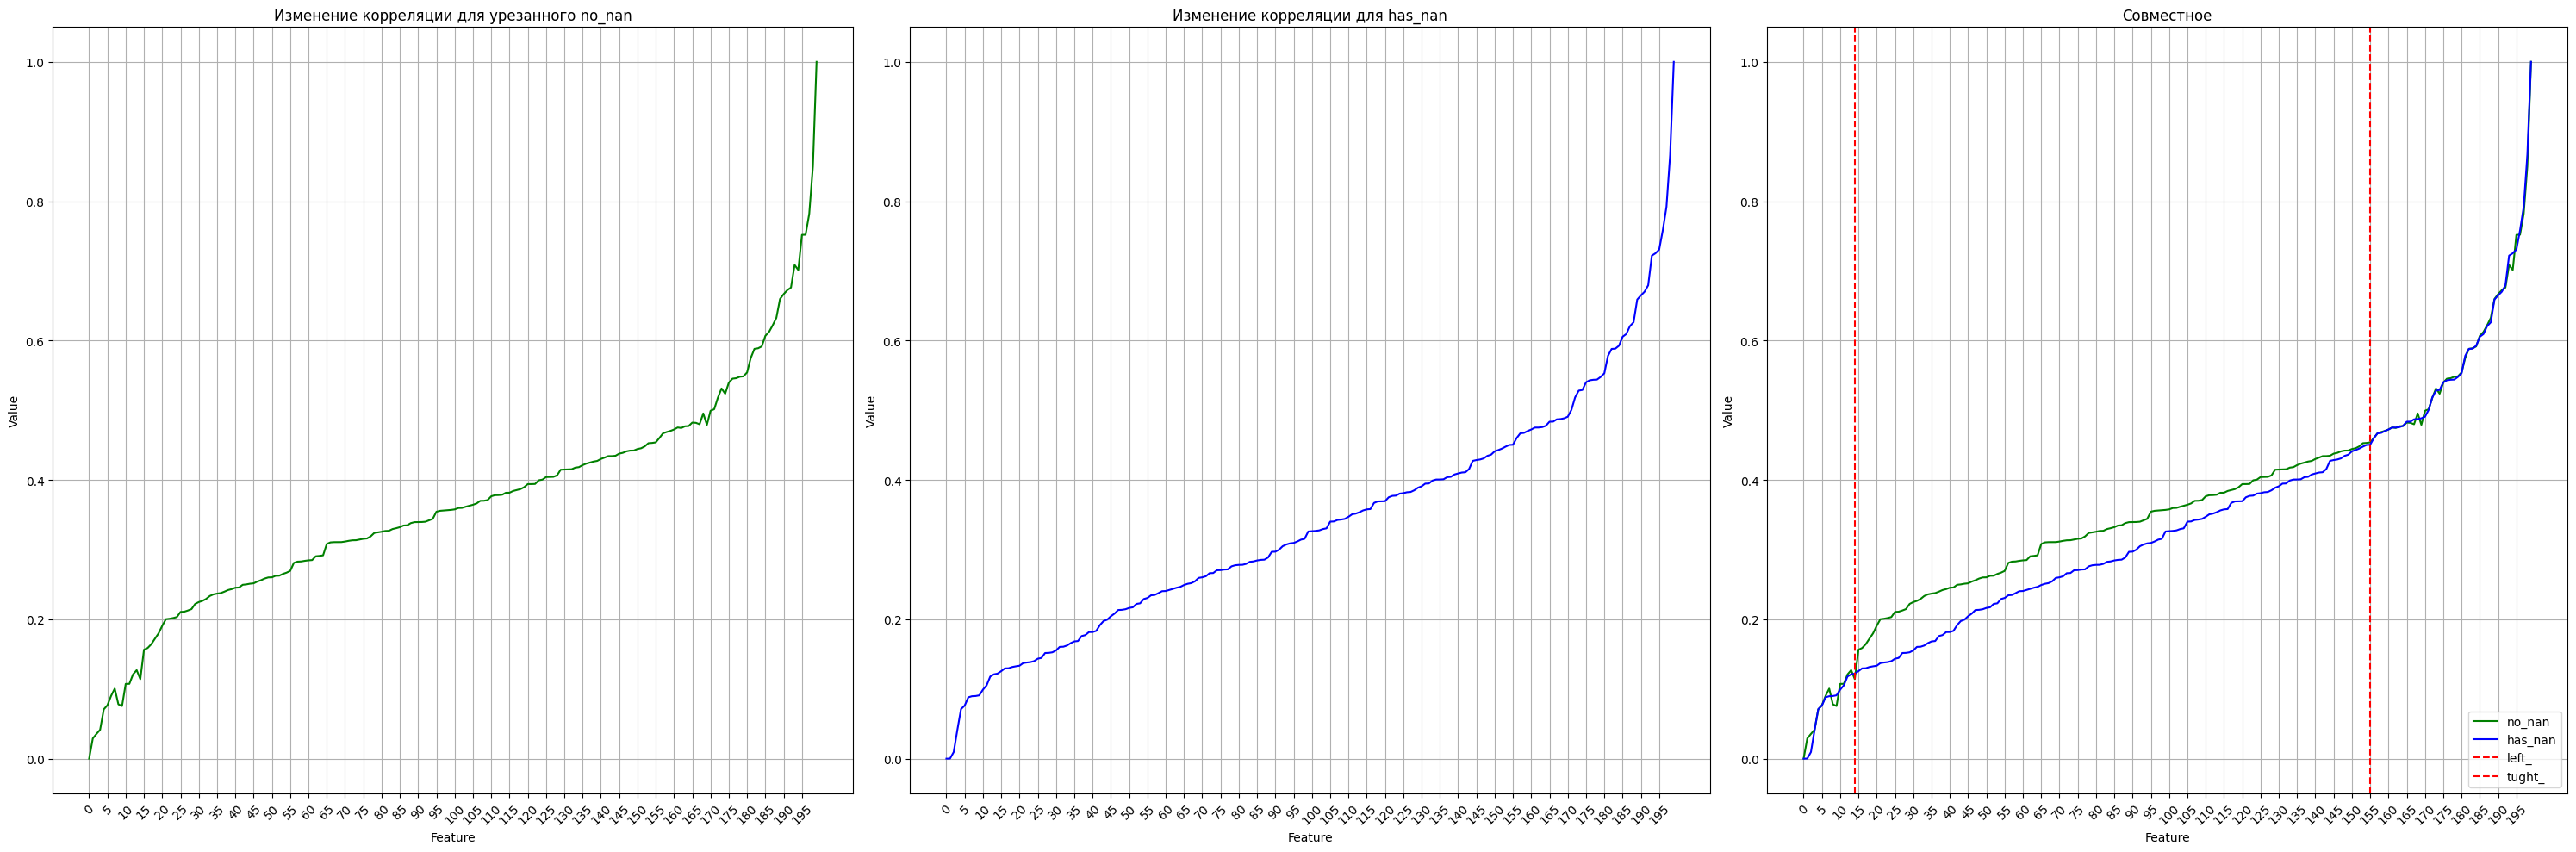

In [20]:
fig, axs = plt.subplots(1,3, figsize=(30, 10))
ax1 = axs[0]
ax1.plot(np.arange(len(test)), test, c = 'g')
ax1.set_xlabel("Feature")
ax1.set_ylabel("Value")
ax1.set_title("Изменение корреляции для урезанного no_nan")
ax1.set_xticks(np.arange(0, 200, 5))
ax1.set_xticklabels(np.arange(0, 200, 5), rotation=45)
ax1.grid()

ax2 = axs[1]
ax2.plot(np.arange(len(np_has_nan)), np_has_nan, c = 'b')
ax2.set_xlabel("Feature")
ax2.set_ylabel("Value")
ax2.set_title("Изменение корреляции для has_nan")
ax2.set_xticks(np.arange(0, 200, 5))
ax2.set_xticklabels(np.arange(0, 200, 5), rotation=45)
ax2.grid()

ax3 = axs[2]
ax3.plot(np.arange(len(test)), test, c = 'g', label = 'no_nan')
ax3.plot(np.arange(len(np_has_nan)), np_has_nan, c = 'b', label = 'has_nan')
plt.axvline(x=14, color='r', linestyle='--', label='left_')  # Первая вертикальная линия
plt.axvline(x=155, color='r', linestyle='--', label='tught_')
ax3.legend()
ax3.set_xlabel("Feature")
ax3.set_ylabel("Value")
ax3.set_title("Совместное")
ax3.set_xticks(np.arange(0, 200, 5))
ax3.set_xticklabels(np.arange(0, 200, 5), rotation=45)
ax3.legend()
ax3.grid()


plt.tight_layout()  # Для лучшего размещения подграфиков
plt.show()

Таким образом мы веделили 2 ярких промежутка: 

1) от 0 до 14 и от 156 до 200 (хвост и голова)
2) от 14 до 156 (туловище)

Одна из наших попыток показала, что качество лучше, когда мы берем серединку (туловище)

In [145]:
prop[14:156]

,ind_has_nan,ind_no_nan,diff,value_has_nan,value_no_nan
14,62,199,0.007956,0.122063,0.114107
15,101,92,0.030777,0.125595,0.156373
16,113,219,0.029258,0.129565,0.158824
17,1,224,0.034509,0.129739,0.164248
18,83,9,0.040663,0.131532,0.172195
...,...,...,...,...,...
151,171,218,0.002595,0.442872,0.445466
152,174,81,0.003127,0.445015,0.448142
153,3,187,0.004922,0.447795,0.452717
154,51,136,0.002913,0.450186,0.453099


In [24]:
index_has_nan = prop["ind_has_nan"].to_numpy()[14:156] # пусть так возьмем серединку
index_no_nan = prop["ind_no_nan"].to_numpy()[14:156] # пусть так возьмем серединку

# Приведем наши датасеты к одной размерности
selected_has_nan = has_nan[:,:,index_has_nan]
selected_no_nan = no_nan[:,:,index_no_nan]

#Соберем нашу new_data
new_data = np.empty((320, 10, 142))
new_data[mask] = selected_has_nan
new_data[~np.array(mask)] = selected_no_nan

new_data.shape

(320, 10, 142)

Напишем функцию для того чтобы для каждого субъекта в has_nan, no_nan выделить 8 максимально скоррелированных.

In [27]:
def group_of_8_correlated(d):
  res = np.empty((0, 8, 2))
  k = 0
  for p1 in range(d.shape[0]): # каждый человек
    subject_cors = np.empty((0,2))
    for p2 in range(d.shape[0]): # каждый человек
      corr = 0
      if p1 == p2: # если совпали, то считаем нулем, нас не иннтересуют собственные корреляции
        continue
      for f in range(d.shape[2]):
        ts_1 = d[p1, :, f]
        ts_2 = d[p2, :, f]

        corr += np.abs(np.corrcoef(ts_1,ts_2)[0, 1])
      subject_cors = np.append(subject_cors, np.array([[corr, p2]]), axis = 0)
    sorted_subject_cors = subject_cors[subject_cors[:, 0].argsort()[::-1]]
    top8 = sorted_subject_cors[:8]
    res = np.vstack((res, top8[None]))
  print("Done")
  return res


In [28]:
fin_no_nan = group_of_8_correlated(selected_no_nan)
fin_has_nan = group_of_8_correlated(selected_has_nan)

Done
Done


Сохраним датасеты

In [ ]:
np.save("fin_no_nan.npy", fin_no_nan)
np.save("fin_has_nan.npy", fin_has_nan)

**Переход от анализа к решению**

In [10]:
# загружаем созданные датасеты
has_nan = np.load('fin_has_nan.npy')
no_nan = np.load('fin_no_nan.npy')
has_nan.shape, no_nan.shape

((160, 8, 2), (160, 8, 2))

In [13]:
has_nan_p = np.arange(160)
no_nan_p = np.arange(160)

In [14]:
for i in range(len(has_nan)):
    has_nan_p[int(has_nan[i, 0, -1])] = has_nan_p[i] # обьединяем в пары самые скорелированные

has_nan_p

array([  0,   1,   0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  18,  25,  30,  31,  32,  33,   9,  35,  36,  37,  38,
        39,  26,  41,  39,  43,  12,  45,  46,  47,  48,  49,  50,  51,
         5,  24,  54,  55,  56,  57,  19,  11,  60,  61,  62,  63,  64,
        65,  66,   7,  68,  69,  70,  70,  72,  73,  72,  13,  46,  21,
         1,   3,   6,  20,  10,  83,  84,  37,  86,  86,  88,  89,  68,
        35,  22,  93,  14,  31,  17,  27,  15,  99,  38, 101, 102,  66,
        48,  51, 106,   4, 108,  84, 110, 111,  63, 113, 108, 115,  16,
       117,  36, 101,  55,  30,  49,  61, 115, 125,  60,  57,  88, 102,
       110, 131, 111,  89,   8,  93,  69,  99,  54,  23,  41,  32, 142,
        45, 117,  43,  56,  33, 113,  50, 106, 142,  83,  62,  73,  65,
       131,  47, 125,  64])

In [15]:
c = 0
# приводим к значениям из [0, 80)
for i in range(160):
    if i in has_nan_p:
        has_nan_p[has_nan_p == i] = c
        c += 1
has_nan_p, max(has_nan_p)

(array([ 0,  1,  0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17, 24, 27, 28, 29, 30,
         8, 31, 32, 33, 34, 35, 25, 36, 35, 37, 11, 38, 39, 40, 41, 42, 43,
        44,  4, 23, 45, 46, 47, 48, 18, 10, 49, 50, 51, 52, 53, 54, 55,  6,
        56, 57, 58, 58, 59, 60, 59, 12, 39, 20,  1,  2,  5, 19,  9, 61, 62,
        33, 63, 63, 64, 65, 56, 31, 21, 66, 13, 28, 16, 26, 14, 67, 34, 68,
        69, 55, 41, 44, 70,  3, 71, 62, 72, 73, 52, 74, 71, 75, 15, 76, 32,
        68, 46, 27, 42, 50, 75, 77, 49, 48, 64, 69, 72, 78, 73, 65,  7, 66,
        57, 67, 45, 22, 36, 29, 79, 38, 76, 37, 47, 30, 74, 43, 70, 79, 61,
        51, 60, 54, 78, 40, 77, 53]),
 79)

In [16]:
# то же самое для второго датасета
for i in range(len(no_nan)):
    no_nan_p[int(no_nan[i, 0, -1])] = no_nan_p[i]
no_nan_p += 80
no_nan_p

array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  89,  95,  96,  97,  98,  99, 100, 101, 102,  99, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 100, 115, 116, 117,  97,
       119, 120, 121, 122, 115, 124, 112, 107, 108, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 117, 138, 139, 140, 109, 142, 143, 144,
        88, 136,  85, 122, 149, 116, 124, 152, 153, 154, 155, 156, 120,
       158, 138, 160, 155, 162, 163, 134,  96, 166, 167,  93,  84, 170,
        87, 172, 173, 113, 106, 176,  83, 167, 156, 160, 158, 182, 144,
        86, 185, 140, 129, 102, 135, 132, 191, 192, 166, 128, 162, 185,
        91, 163, 172, 200, 192, 105,  80, 143, 153, 182, 207, 111, 149,
       210, 207, 133, 213,  92, 139, 154, 119, 176, 142, 110, 210,  98,
        82,  90, 173, 131, 101, 200,  95, 230,  81, 104, 191, 130, 230,
       170, 152, 213, 121])

In [17]:
c = 80
for i in range(80, 80+160):
    if i in no_nan_p:
        no_nan_p[no_nan_p == i] = c
        c += 1
no_nan_p, max(no_nan_p)

(array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  89,  94,  95,  96,  97,  98,  99, 100, 101,  98, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111,  99, 112, 113, 114,  96,
        115, 116, 117, 118, 112, 119, 110, 105, 106, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 114, 129, 130, 131, 107, 132, 133, 134,
         88, 128,  85, 118, 135, 113, 119, 136, 137, 138, 139, 140, 116,
        141, 129, 142, 139, 143, 144, 126,  95, 145, 146,  93,  84, 147,
         87, 148, 149, 111, 104, 150,  83, 146, 140, 142, 141, 151, 134,
         86, 152, 131, 121, 101, 127, 124, 153, 154, 145, 120, 143, 152,
         91, 144, 148, 155, 154, 103,  80, 133, 137, 151, 156, 109, 135,
        157, 156, 125, 158,  92, 130, 138, 115, 150, 132, 108, 157,  97,
         82,  90, 149, 123, 100, 155,  94, 159,  81, 102, 153, 122, 159,
        147, 136, 158, 117]),
 159)

In [18]:
len(set(no_nan_p)), len(set(has_nan_p)) # смотрим, что все правильно

(80, 80)

In [19]:
# обьединяем по маске
preds = np.zeros(data.shape[0], dtype=int)
preds[mask] = has_nan_p
preds[~np.array(mask)] = no_nan_p
preds

array([ 80,   0,  81,  82,   1,   0,  83,  84,   2,   3,   4,  85,  86,
         5,  87,   6,   7,   8,   9,  88,  89,  90,  10,  91,  92,  11,
        12,  93,  13,  89,  14,  94,  95,  15,  96,  97,  16,  98,  17,
        18,  19,  99, 100,  20,  21, 101,  98,  22, 102, 103, 104,  23,
       105,  24,  25,  26, 106,  17,  24,  27,  28,  29, 107, 108,  30,
       109,   8,  31, 110,  32,  33, 111,  99,  34,  35,  25, 112,  36,
       113,  35, 114,  37,  96, 115,  11, 116,  38, 117,  39, 118,  40,
       112,  41,  42,  43, 119, 110,  44,   4,  23, 105, 106,  45,  46,
       120,  47,  48,  18, 121,  10,  49,  50,  51, 122, 123,  52,  53,
       124, 125,  54, 126, 127, 128,  55,   6, 114, 129, 130,  56, 131,
       107,  57,  58,  58, 132,  59,  60, 133,  59, 134,  12,  39,  88,
        20,   1,   2,   5,  19, 128,  85,   9, 118, 135,  61,  62,  33,
       113,  63, 119,  63,  64,  65, 136,  56, 137,  31, 138, 139, 140,
        21,  66, 116, 141,  13, 129, 142, 139,  28, 143, 144,  1

In [20]:
len(set(preds)) # смотрим, что все правильно

160

In [ ]:
pd.DataFrame({'prediction': preds}).to_csv('best_submission.csv', index=False)